# GRU Forecasting Bitcoin Price

---





## 1. Introduction

Historical data of cryptocurrency prices will be used to predict Adjusted Close prices by building a multi-layer Recurrent Neural Network model. The ability to store information over a period of time is useful when dealing with time series data.


##2. Import/Install Library

In [1]:
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import math
import datetime
import keras
import warnings
import tensorflow as tf
import random as rn
warnings.filterwarnings('ignore')

from datetime import date, timedelta
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU, GRU, Bidirectional
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from google.colab import data_table
data_table.enable_dataframe_formatter()

%matplotlib inline

## 3. Import data

Read in cryptocurrency data  downloaded from Yahoo! Finance using yfinance API into a pandas DataFrame.

In [2]:
### Unduh data dengan API Yfinance dan dijadikan DataFrame
#stock_kode = input("Masukkan Simbol Kode Saham : ")
#range_start_historical_data = input("Masukkan rentang awal historical data format: yyyy-mm-dd : ")
#range_end_historical_data = input("Masukkan rentang akhir historical data format: yyyy-mm-dd : ")
#stock_kode_df = yf.download(stock_kode, range_start_historical_data, range_end_historical_data)

In [3]:
stock_kode = "BNB-USD"##input("Masukkan Simbol Kode Saham : ")
stock_kode_df = yf.download(stock_kode, start = "2018-08-04", end = "2023-08-04")
stock_kode_df.to_csv("data.csv")

df = pd.read_csv("data.csv")
df['Date'] = pd.to_datetime(df['Date'])

print(df['Date'])
print(df['Date'].tail(1))

[*********************100%%**********************]  1 of 1 completed
0      2018-08-04
1      2018-08-05
2      2018-08-06
3      2018-08-07
4      2018-08-08
          ...    
1821   2023-07-30
1822   2023-07-31
1823   2023-08-01
1824   2023-08-02
1825   2023-08-03
Name: Date, Length: 1826, dtype: datetime64[ns]
1825   2023-08-03
Name: Date, dtype: datetime64[ns]


In [4]:
stock_kode_df.tail

<bound method NDFrame.tail of                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-08-04   14.112700   14.455100   13.569100   13.842400   13.842400   
2018-08-05   13.858700   13.897800   13.287500   13.623200   13.623200   
2018-08-06   13.687600   13.975700   13.496400   13.699100   13.699100   
2018-08-07   13.658500   13.908800   13.128600   13.146100   13.146100   
2018-08-08   13.128900   13.139200   11.980700   12.143700   12.143700   
...                ...         ...         ...         ...         ...   
2023-07-30  242.582214  243.785721  240.925186  242.525986  242.525986   
2023-07-31  242.519592  244.202576  240.764450  241.120651  241.120651   
2023-08-01  241.128052  247.505020  238.530243  247.505020  247.505020   
2023-08-02  247.490311  248.511551  236.891769  240.494644  240.494644   
2023-08-03  240.509979  241.583252  238.509644  241.061523  241.061523   

       

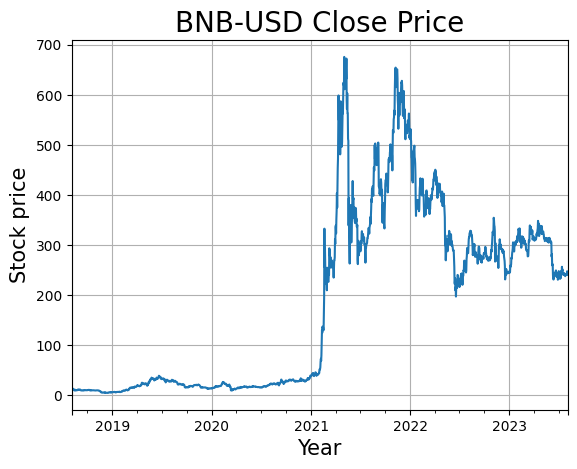

In [5]:
# Plot Adjusted Close price

stock_kode_df['Adj Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(14, 8)})
plt.title(stock_kode + ' Close Price', color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock price', color = 'black', fontsize = 15);
plt.savefig("plotBNB.png")

In [6]:
# Create DataFrame for Adjusted Close price
stock_kode_adj = stock_kode_df[['Adj Close']]

In [7]:
# Print DataFrame
stock_kode_adj

,Adj Close
Date,
2018-08-04,13.842400
2018-08-05,13.623200
2018-08-06,13.699100
2018-08-07,13.146100
2018-08-08,12.143700
...,...
2023-07-30,242.525986
2023-07-31,241.120651
2023-08-01,247.505020


##4. Create Training Data-set

In [8]:
# Convert DataFrame to numpy array
stock_kode_adj_arr = stock_kode_adj.values

# Find number of rows to train model on (80% of data set)
training_data_len = int(0.8*len(stock_kode_adj))

# Print
training_data_len

1460

In [9]:
# Create train data set

train = stock_kode_adj_arr[0:training_data_len, :]

In [10]:
train

array([[ 13.8423996 ],
       [ 13.62320042],
       [ 13.69909954],
       ...,
       [283.57946777],
       [283.53948975],
       [283.82098389]])

### Normalisasi Data / Feature scaling

Normalisasi data latihan sebelum memasukkan model dengan mengonversi nilai kolom numerik dalam set data menjadi skala umum. Fungsi MinMaxScaler() dari Scikit-Learn akan menyesuaikan skala data menjadi nilai antara 0 dan 1 yang membantu meningkatkan performa.

In [11]:
# Normalise the data
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train)

In [12]:
# Print Normalized Data
print(train_scaled)

[[0.01387719]
 [0.01355059]
 [0.01366368]
 ...
 [0.41577674]
 [0.41571717]
 [0.41613659]]


In [13]:
train_scaled.shape

(1460, 1)

### Split training data into X_train, y_train

Kode berikut merupakan implementasi dari pembuatan data struktur untuk data time series dalam bentuk supervised learning. Data time series diubah menjadi data supervised learning dengan membuat data input (X) dan data output (y) dari data time series yang diberikan.

Kode tersebut melakukan hal berikut:

Membuat dua variabel kosong X_train dan y_train sebagai list untuk menampung data input dan output.
Melakukan iterasi untuk setiap time-step pada data latihan (train_scaled) dimulai dari time-step ke-60 hingga akhir data.
Pada setiap iterasi, dilakukan penambahan data input dan output ke dalam list X_train dan y_train. Data input (X_train) berupa 60 time-step sebelum time-step saat ini (i-60) dan data output (y_train) adalah time-step saat ini (i) pada kolom pertama (0) pada data latihan (train_scaled).
Jika i <= 61, maka akan menampilkan data input dan output pada iterasi tersebut untuk memastikan data terbentuk dengan benar. Hal ini digunakan untuk debugging dan tidak diperlukan pada saat eksekusi sebenarnya.
Dengan menggunakan kode tersebut, data time series dapat diubah menjadi data supervised learning yang dapat digunakan untuk melatih model machine learning untuk melakukan prediksi.

In [14]:
# Creating a data structure with 60 time-steps and 1 output

# Split data into X_train and y_train data sets
X_train = []
y_train = []
# Creating a data structure with 60 time-steps and 1 output
for i in range(60, len(train_scaled)):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i:i+1, 0])
    if i <= 61:     # 60 days for first pass, 61 for second
      print(X_train)
      print(y_train)
      print()

[array([0.01387719, 0.01355059, 0.01366368, 0.01283972, 0.01134618,
       0.01241046, 0.01132696, 0.01073961, 0.01074736, 0.00849215,
       0.00728812, 0.00735204, 0.00785761, 0.00944513, 0.00801443,
       0.00838487, 0.00770653, 0.00772694, 0.00746635, 0.00772755,
       0.00850183, 0.00835447, 0.00842867, 0.00995917, 0.01036638,
       0.00990061, 0.00928839, 0.00966266, 0.0102074 , 0.0100882 ,
       0.01003113, 0.0101773 , 0.00828117, 0.00857558, 0.00820771,
       0.00743707, 0.00742597, 0.00744421, 0.00721936, 0.00698166,
       0.0075622 , 0.00804791, 0.00831648, 0.00805681, 0.00726599,
       0.0074728 , 0.00758459, 0.00826314, 0.00876421, 0.00851718,
       0.00857022, 0.00820563, 0.00782905, 0.00775972, 0.00819862,
       0.00810645, 0.00815085, 0.00817866, 0.00806819, 0.00868376])]
[array([0.00855622])]

[array([0.01387719, 0.01355059, 0.01366368, 0.01283972, 0.01134618,
       0.01241046, 0.01132696, 0.01073961, 0.01074736, 0.00849215,
       0.00728812, 0.00735204, 0.00

In [15]:
# Convert X_train and y_train to numpy arrays for training GRU model
X_train, y_train = np.array(X_train), np.array(y_train)

In [16]:
# Reshape the data as GRU expects 3-D data (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1400, 60, 1)

##5. Create test set

In [17]:
# Create Data Test
test = stock_kode_adj_arr[training_data_len: , :]

In [18]:
print(test.shape)

(366, 1)


In [19]:
print(test)

[[298.35678101]
 [310.70605469]
 [315.18554688]
 [315.06890869]
 [322.92114258]
 [324.80041504]
 [324.912323  ]
 [328.47116089]
 [323.80023193]
 [327.51467896]
 [323.87014771]
 [317.9866333 ]
 [319.88729858]
 [316.42367554]
 [306.63641357]
 [298.14123535]
 [279.71871948]
 [283.69314575]
 [302.05627441]
 [300.55911255]
 [299.02993774]
 [296.44967651]
 [301.58364868]
 [279.59817505]
 [277.80157471]
 [276.25088501]
 [286.22140503]
 [281.425354  ]
 [279.23809814]
 [278.41723633]
 [277.41610718]
 [277.77557373]
 [278.84185791]
 [276.68591309]
 [262.668396  ]
 [278.76132202]
 [280.57748413]
 [293.40713501]
 [296.96905518]
 [295.16186523]
 [293.65872192]
 [277.57693481]
 [279.38586426]
 [270.80688477]
 [274.65457153]
 [279.24932861]
 [266.31317139]
 [272.06982422]
 [266.36959839]
 [264.79208374]
 [275.50027466]
 [276.62625122]
 [275.13537598]
 [274.06124878]
 [275.92785645]
 [272.40155029]
 [281.78121948]
 [283.78903198]
 [284.19229126]
 [282.87191772]
 [284.43310547]
 [287.03198242]
 [296.29

In [20]:
# Predicting 253 values, using past 60 from the train data
inputs = stock_kode_adj_arr[len(stock_kode_adj_arr) - len(test) - 60:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [21]:
inputs

array([[0.44267314],
       [0.43865558],
       [0.43338303],
       [0.42585139],
       [0.42328114],
       [0.4252234 ],
       [0.41945283],
       [0.39477942],
       [0.37461104],
       [0.32477892],
       [0.32584494],
       [0.34100605],
       [0.30545844],
       [0.31492429],
       [0.28684019],
       [0.31347714],
       [0.31647753],
       [0.32029835],
       [0.31249582],
       [0.33438618],
       [0.35119981],
       [0.35038383],
       [0.34169447],
       [0.34138943],
       [0.33136689],
       [0.31997926],
       [0.32000254],
       [0.31510854],
       [0.31811794],
       [0.31952608],
       [0.33829046],
       [0.33720611],
       [0.34860969],
       [0.35314601],
       [0.35196328],
       [0.35567383],
       [0.34288172],
       [0.32977436],
       [0.32173755],
       [0.33672694],
       [0.34810986],
       [0.34872003],
       [0.3651393 ],
       [0.36253872],
       [0.38792415],
       [0.39378162],
       [0.37816897],
       [0.388

In [22]:
# Create data sets X_test and y_test
X_test = []
y_test = stock_kode_adj_arr[training_data_len:, :]
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])

In [23]:
# Convert data to numpy array
X_test = np.array(X_test)

In [24]:
# Reshape data to be 3-D.
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [25]:
print(X_test.shape)

(366, 60, 1)


In [26]:
X_test

array([[[0.44267314],
        [0.43865558],
        [0.43338303],
        ...,
        [0.41577674],
        [0.41571717],
        [0.41613659]],

       [[0.43865558],
        [0.43338303],
        [0.42585139],
        ...,
        [0.41571717],
        [0.41613659],
        [0.43779446]],

       [[0.43338303],
        [0.42585139],
        [0.42328114],
        ...,
        [0.41613659],
        [0.43779446],
        [0.45619448]],

       ...,

       [[0.45130402],
        [0.45025557],
        [0.44792627],
        ...,
        [0.35468344],
        [0.35460837],
        [0.35251447]],

       [[0.45025557],
        [0.44792627],
        [0.40580853],
        ...,
        [0.35460837],
        [0.35251447],
        [0.36202697]],

       [[0.44792627],
        [0.40580853],
        [0.41267181],
        ...,
        [0.35251447],
        [0.36202697],
        [0.35158174]]])

##6. Creating Model and Train

###Define Hyperparameter Untuk Model

In [27]:
# Define hyperparameters
learning_rate = 0.0001
num_neurons = 100
dropout_rate = 0.2
num_epochs = 200
batch_size = 64

###Model GRU

In [28]:
# Set random seed for consistency of training
np.random.seed(8)
rn.seed(8)
tf.random.set_seed(8)

# Build model - GRU with 100 neurons and 5 hidden layers
model_gru = Sequential()
model_gru.add(LSTM(units = num_neurons, return_sequences = True, input_shape = (X_train.shape[1], 1), activation='tanh'))
model_gru.add(Dropout(dropout_rate))
model_gru.add(LSTM(units = num_neurons, return_sequences = True, activation='tanh'))
model_gru.add(Dropout(dropout_rate))
model_gru.add(LSTM(units = num_neurons, return_sequences = True, activation='tanh'))
model_gru.add(Dropout(dropout_rate))
model_gru.add(LSTM(units = num_neurons, activation='tanh'))
model_gru.add(Dropout(dropout_rate))

# Adding the output layer
model_gru.add(Dense(units = 1))

# Compiling the RNN with Adam optimizer and mean squared error as the loss function
opt = keras.optimizers.Adam(lr=learning_rate)
model_gru.compile(optimizer = opt, loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model_gru.fit(X_train, y_train, epochs = num_epochs, batch_size = batch_size)

Epoch 1/200
22/22 [==============================] - 20s 23ms/step - loss: 0.0266
Epoch 2/200
22/22 [==============================] - 0s 20ms/step - loss: 0.0064
Epoch 3/200
22/22 [==============================] - 0s 19ms/step - loss: 0.0049
Epoch 4/200
22/22 [==============================] - 0s 18ms/step - loss: 0.0041
Epoch 5/200
22/22 [==============================] - 0s 20ms/step - loss: 0.0038
Epoch 6/200
22/22 [==============================] - 0s 15ms/step - loss: 0.0038
Epoch 7/200
22/22 [==============================] - 0s 14ms/step - loss: 0.0039
Epoch 8/200
22/22 [==============================] - 0s 15ms/step - loss: 0.0040
Epoch 9/200
22/22 [==============================] - 0s 13ms/step - loss: 0.0031
Epoch 10/200
22/22 [==============================] - 0s 14ms/step - loss: 0.0032
Epoch 11/200
22/22 [==============================] - 0s 14ms/step - loss: 0.0031
Epoch 12/200
22/22 [==============================] - 0s 13ms/step - loss: 0.0026
Epoch 13/200
22/22 [====

## 7. Make Predictions using the test set

In [29]:
# We want predictions to contain same values as y_test data set
predictions_gru = model_gru.predict(X_test)
predictions_gru = scaler.inverse_transform(predictions_gru)
print("Prediction Shape", predictions_gru.shape)

12/12 [==============================] - 2s 8ms/step
Prediction Shape (366, 1)


In [30]:
predictions_gru

array([[281.09738],
       [291.66742],
       [306.9933 ],
       [316.50177],
       [317.52496],
       [319.86752],
       [323.12073],
       [325.00174],
       [327.65134],
       [326.54242],
       [327.00626],
       [325.86163],
       [321.194  ],
       [319.20224],
       [317.47766],
       [310.87598],
       [301.47345],
       [286.5601 ],
       [280.38202],
       [291.84967],
       [301.3772 ],
       [301.6816 ],
       [296.9361 ],
       [296.73053],
       [286.65442],
       [277.79913],
       [274.8299 ],
       [281.38605],
       [284.47586],
       [282.01147],
       [278.31677],
       [275.88837],
       [275.56   ],
       [276.7763 ],
       [276.59308],
       [268.22098],
       [270.31238],
       [277.16254],
       [288.06155],
       [295.6635 ],
       [296.11734],
       [293.2175 ],
       [282.66177],
       [276.91284],
       [272.62582],
       [273.0892 ],
       [277.42734],
       [272.79907],
       [269.71564],
       [266.34586],


##8. Calculate the RMSE using the actual values
RMSE is the standard deviation of the residuals and is a good measure of how accurately the model predicts the reponse. Lower values of RMSE indicate a better fit.

In [31]:
rmse_gru = np.sqrt(np.mean((predictions_gru - y_test)**2))
mape_gru = np.mean(np.abs((y_test - predictions_gru) / y_test)) * 100

print("RMSE:", rmse_gru)
print("MAPE:", mape_gru)

RMSE: 8.62594229006221
MAPE: 1.9884212136319075


9. ## DataFrame of actual vs predicted prices

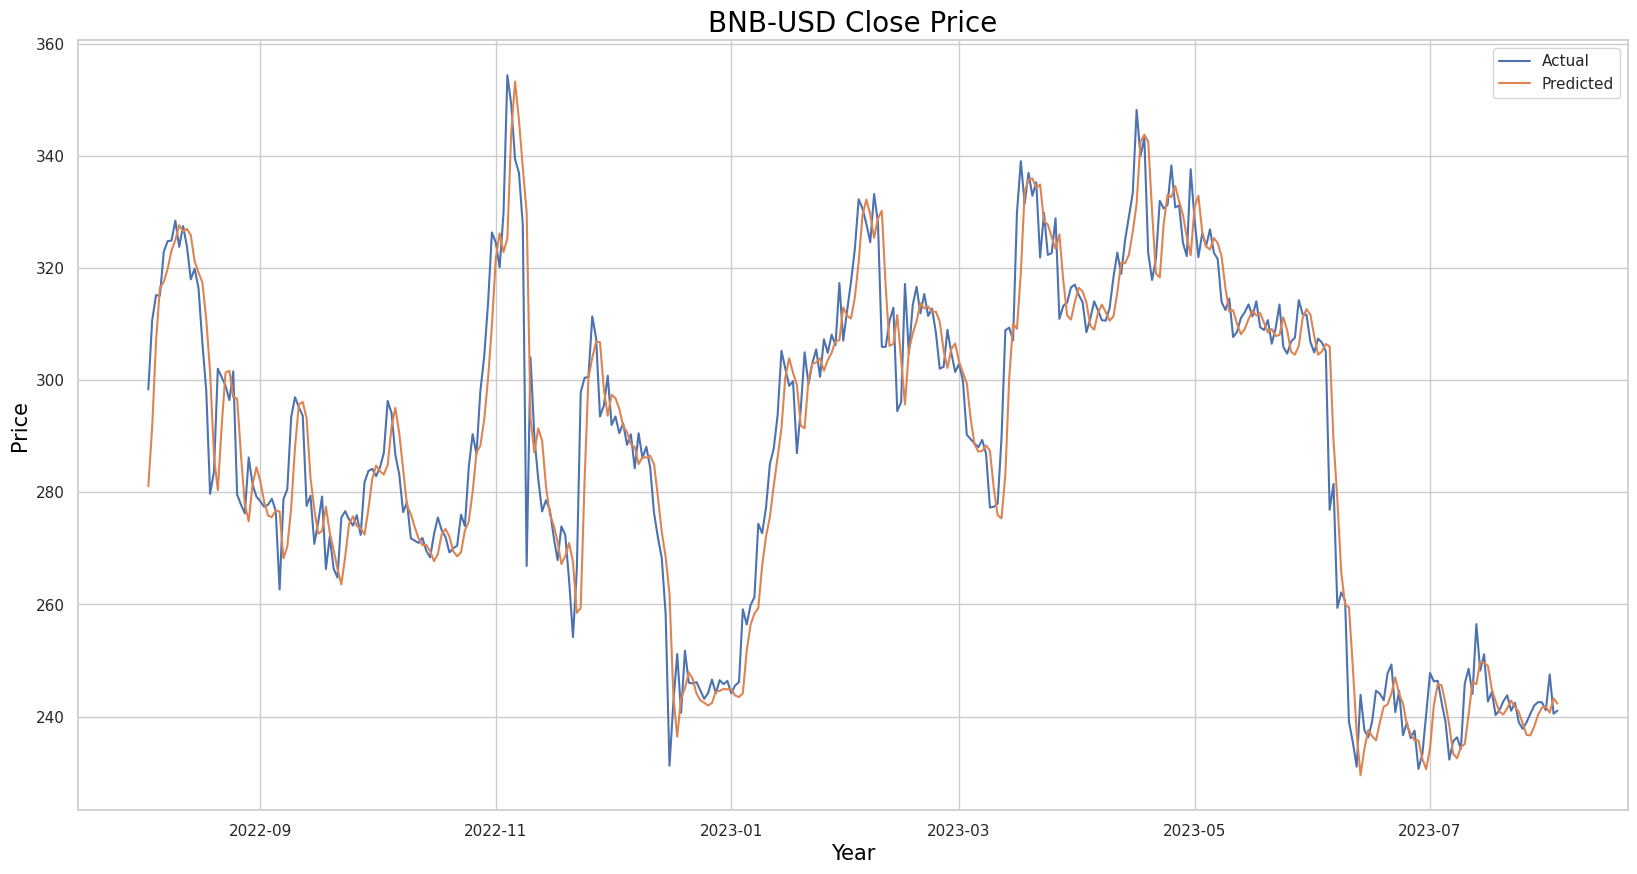

In [32]:
# Plot predicted vs actual values
#train =stock_kode_adj[:training_data_len]
test = stock_kode_adj[training_data_len:]
test['Predictions'] = predictions_gru

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
#plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title(stock_kode +" Close Price", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Price', color = 'black', fontsize = 15)
plt.legend();
plt.savefig("BNB-GRU.png")

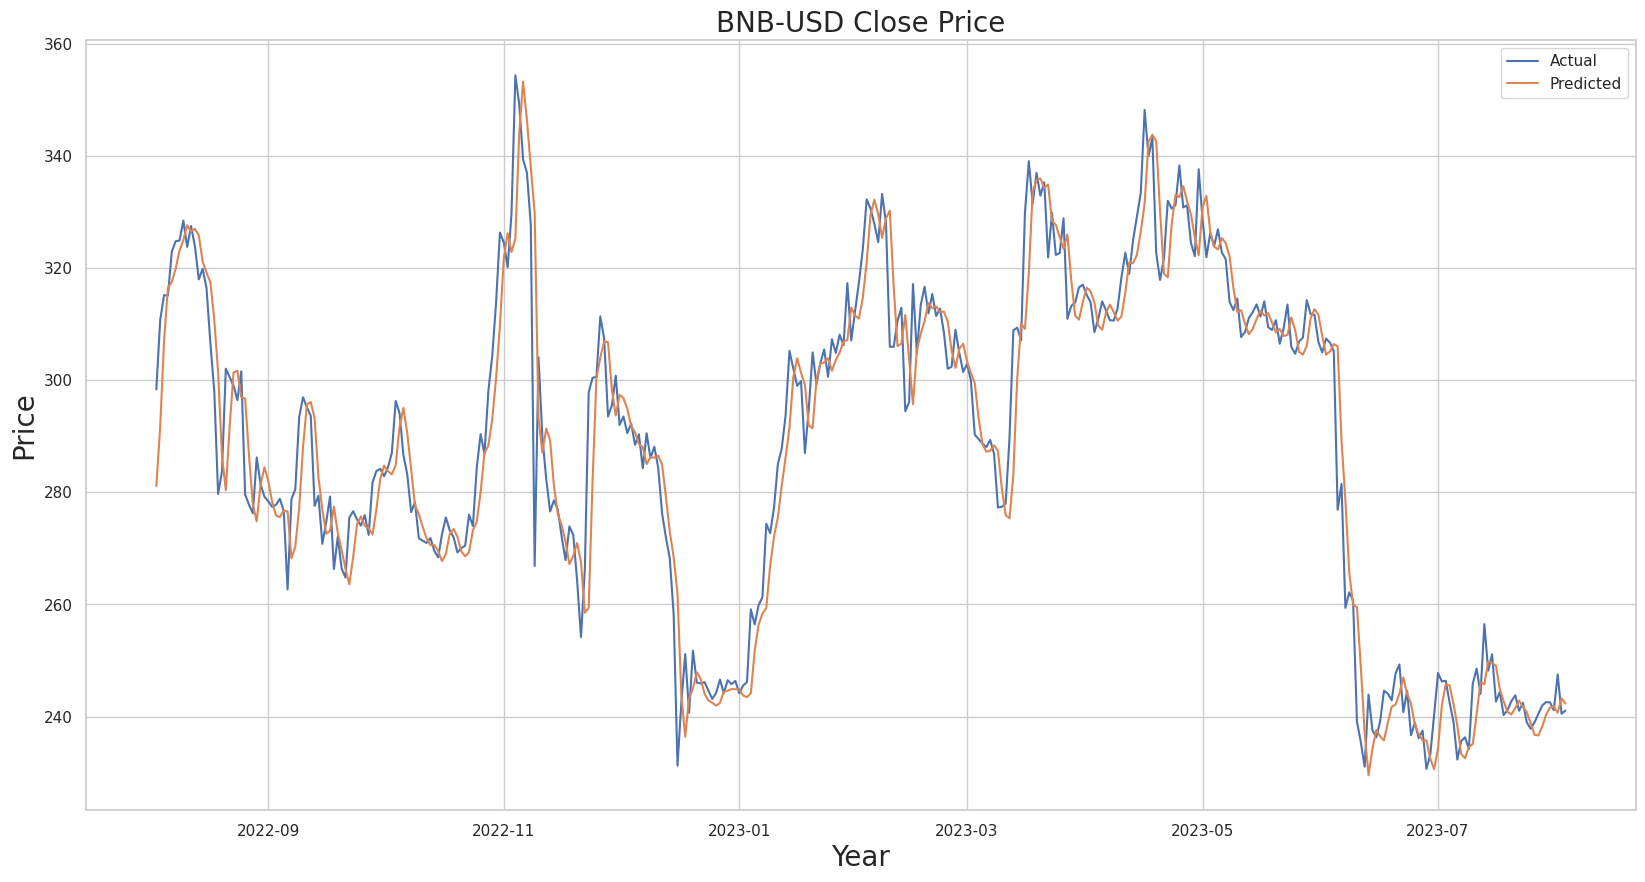

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have 'test' DataFrame with 'Adj Close' and 'Predictions' columns

plt.figure(figsize=(20, 10))
sns.set_style("whitegrid")

plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title(stock_kode + " Close Price", fontsize=20)
plt.xlabel('Year', fontsize=20)  # Increase the fontsize here
plt.ylabel('Price', fontsize=20)  # Increase the fontsize here
plt.legend()

plt.savefig("BNB-GRU.png")
plt.show()  # Add this line to display the plot


1/1 [==============================] - 1s 1s/step


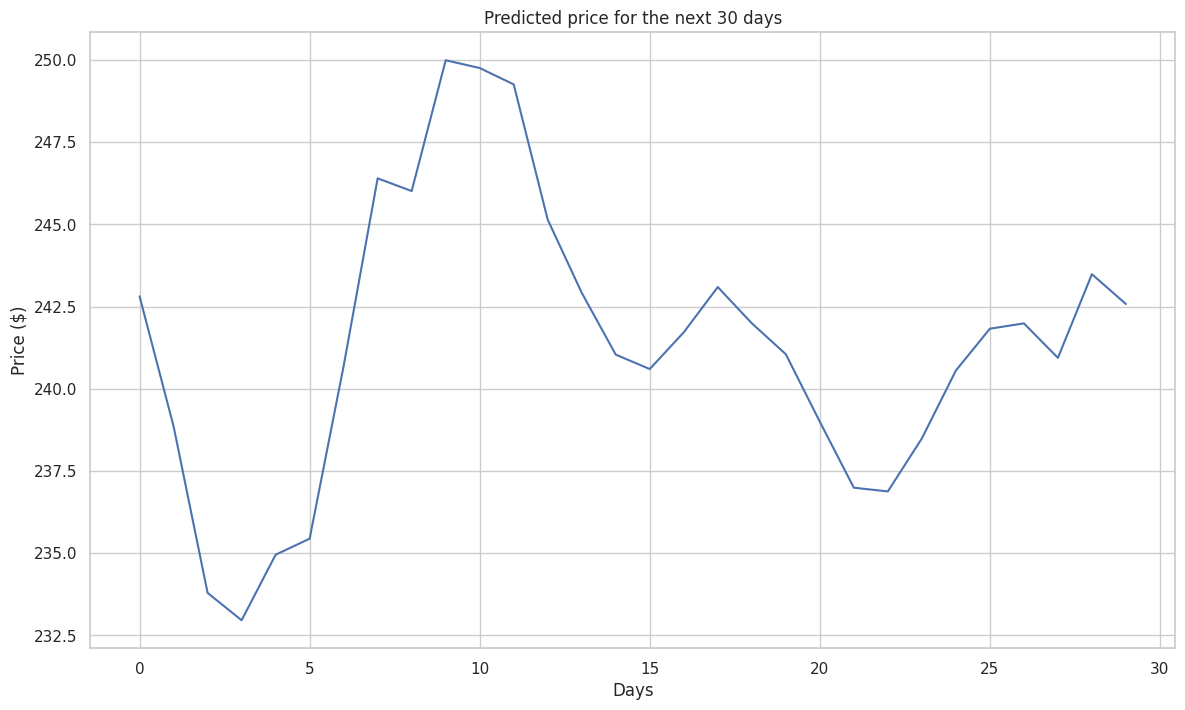

In [34]:
# Predicting 30 days into the future, using past 60 from the train data
future_days = 30
inputs = stock_kode_adj_arr[len(stock_kode_adj_arr) - 60:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_future = []
for i in range(future_days, len(inputs)):
    X_future.append(inputs[i-future_days:i, 0])

X_future = np.array(X_future)
X_future = np.reshape(X_future, (X_future.shape[0], X_future.shape[1], 1))

predicted_price = model_gru.predict(X_future)
predicted_price = scaler.inverse_transform(predicted_price)


# Plot the predicted price
plt.plot(predicted_price)
plt.title(f"Predicted price for the next {future_days} days")
plt.xlabel("Days")
plt.ylabel("Price ($)")
plt.show()


In [35]:
# Menampilkan 7 data teratas hasil prediksi
top_7_predicted = predicted_price[:7]
print(top_7_predicted)

[[242.81293]
 [238.86113]
 [233.79411]
 [232.96175]
 [234.95448]
 [235.44283]
 [240.6941 ]]


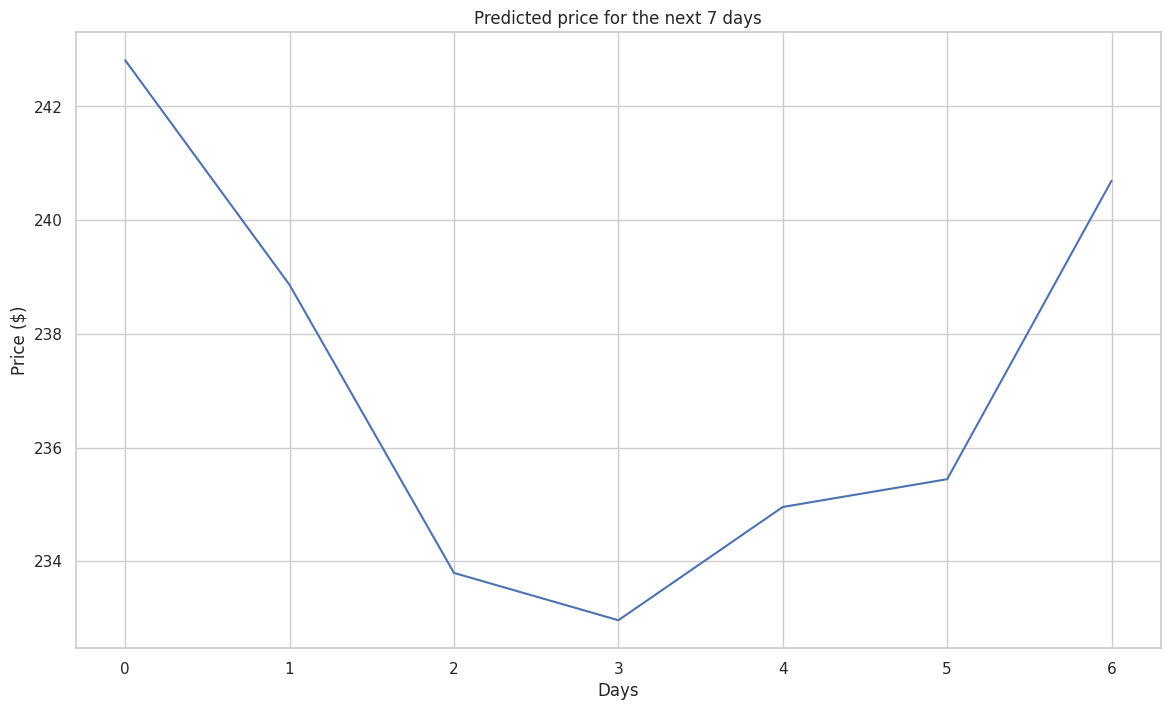

In [36]:
# Plot the predicted price
plt.plot(top_7_predicted)
plt.title(f"Predicted price for the next 7 days")
plt.xlabel("Days")
plt.ylabel("Price ($)")
plt.show()

In [37]:
 # Predicting 60 days into the future, using past 60 from the train data
future_days = 30
inputs = stock_kode_adj_arr[len(stock_kode_adj_arr) - 60:]
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

X_future = []
for i in range(future_days, len(inputs)):
  X_future.append(inputs[i - future_days:i, 0])

X_future = np.array(X_future)
X_future = np.reshape(X_future, (X_future.shape[0], X_future.shape[1], 1))

predicted_price = model_gru.predict(X_future)
predicted_price = scaler.inverse_transform(predicted_price)

# Print the predicted prices and dates
last_date = df['Date'].iloc[-1]


dates = pd.date_range(start=last_date, periods=future_days+1, freq='D')[1:]
for date, price in zip(dates, predicted_price):
    print(f"Predicted price for {date.date()} is {price[0]:.2f} $")

1/1 [==============================] - 0s 34ms/step
Predicted price for 2023-08-04 is 242.81 $
Predicted price for 2023-08-05 is 238.86 $
Predicted price for 2023-08-06 is 233.79 $
Predicted price for 2023-08-07 is 232.96 $
Predicted price for 2023-08-08 is 234.95 $
Predicted price for 2023-08-09 is 235.44 $
Predicted price for 2023-08-10 is 240.69 $
Predicted price for 2023-08-11 is 246.40 $
Predicted price for 2023-08-12 is 246.01 $
Predicted price for 2023-08-13 is 249.99 $
Predicted price for 2023-08-14 is 249.76 $
Predicted price for 2023-08-15 is 249.26 $
Predicted price for 2023-08-16 is 245.14 $
Predicted price for 2023-08-17 is 242.92 $
Predicted price for 2023-08-18 is 241.04 $
Predicted price for 2023-08-19 is 240.60 $
Predicted price for 2023-08-20 is 241.72 $
Predicted price for 2023-08-21 is 243.10 $
Predicted price for 2023-08-22 is 241.99 $
Predicted price for 2023-08-23 is 241.05 $
Predicted price for 2023-08-24 is 239.00 $
Predicted price for 2023-08-25 is 236.99 $
Pr

In [38]:
predicted_price

array([[242.81293],
       [238.86113],
       [233.79411],
       [232.96175],
       [234.95448],
       [235.44283],
       [240.6941 ],
       [246.40224],
       [246.01472],
       [249.9934 ],
       [249.75694],
       [249.25868],
       [245.14464],
       [242.92105],
       [241.04066],
       [240.60152],
       [241.71953],
       [243.09575],
       [241.99422],
       [241.05247],
       [239.00014],
       [236.99303],
       [236.87964],
       [238.49118],
       [240.55632],
       [241.8285 ],
       [241.99083],
       [240.94212],
       [243.48651],
       [242.57874]], dtype=float32)